<a href="https://colab.research.google.com/github/sajeebju/Deep-Learning/blob/main/3D_FaultSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Prediction with a pre-trained U-net model
#FaultSeg3D: using synthetic datasets to train an end-to-end convolutional neural network
#for 3D seismic fault segmentation

In [ ]:
from keras.models import load_model
import tensorflow as tf
json_file = open('/content/drive/MyDrive/Python/UNET/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Python/UNET/pretrained_model.hdf5")
print("Loaded model from disk")

# training image dimensions
n1, n2, n3 = 128, 128, 128

Loaded model from disk


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set gaussian weights in the overlap bounaries
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [ ]:
gx,m1,m2,m3 = np.fromfile("/content/drive/MyDrive/Python/UNET/seismic/3.dat",dtype=np.single),128,128,128
gx

array([-1.458815  , -0.532674  , -0.66286504, ..., -0.70293826,
       -1.1069921 , -0.6420677 ], dtype=float32)

1/1 [==============================] - 1s 645ms/step


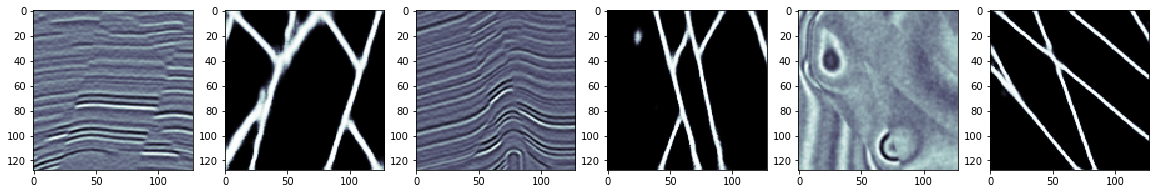

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

gx,m1,m2,m3 = np.fromfile("/content/drive/MyDrive/Python/UNET/seismic/3.dat",dtype=np.single),128,128,128
gx = gx-np.min(gx)
gx = gx/np.max(gx)
gx = gx*255
k = 50
x = np.reshape(gx,(1,n1,n2,n3,1))
Y = loaded_model.predict(x,verbose=1)
fig = plt.figure(figsize=(20,20))

#inline slice
k1 = 50
plt.subplot(1, 6, 1)
imgplot1 = plt.imshow(np.transpose(x[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 2)
imgplot2 = plt.imshow(np.transpose(Y[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)

#xline slice
k2 = 110
plt.subplot(1, 6, 3)
imgplot1 = plt.imshow(np.transpose(x[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 4)
imgplot2 = plt.imshow(np.transpose(Y[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)

#time slice
k3 = 60
plt.subplot(1, 6, 5)
imgplot1 = plt.imshow(np.transpose(x[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 6)
imgplot2 = plt.imshow(np.transpose(Y[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct!!!
#we strongly suggest to gain the seismic image before input it to the faultSeg!!!
gx,m1,m2,m3 = np.fromfile("/content/drive/MyDrive/Python/UNET/f3d/gxl.dat",dtype=np.single),512,384,128
os = 12 #overlap width
c1 = np.round((m1+os)/(n1-os)+0.5)
c2 = np.round((m2+os)/(n2-os)+0.5)
c3 = np.round((m3+os)/(n3-os)+0.5)
c1 = int(c1)
c2 = int(c2)
c3 = int(c3)
p1 = (n1-os)*c1+os
p2 = (n2-os)*c2+os
p3 = (n3-os)*c3+os
gx = np.reshape(gx,(m1,m2,m3))
gp = np.zeros((p1,p2,p3),dtype=np.single)
gy = np.zeros((p1,p2,p3),dtype=np.single)
mk = np.zeros((p1,p2,p3),dtype=np.single)
gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
gp[0:m1,0:m2,0:m3]=gx
sc = getMask(os)
for k1 in range(c1):
    for k2 in range(c2):
        for k3 in range(c3):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2
            b3 = k3*n3-k3*os
            e3 = b3+n3
            gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
            gs = gs-np.min(gs)
            gs = gs/np.max(gs)
            gs = gs*255
            Y = loaded_model.predict(gs,verbose=1)
            Y = np.array(Y)
            gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
            mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
gy = gy/mk
gy = gy[0:m1,0:m2,0:m3]
gy.tofile("/content/drive/MyDrive/Python/UNET/f3d/"+"fp.dat",format="%4")

1/1 [==============================] - 1s 511ms/step


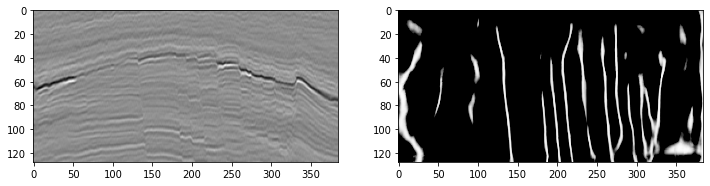

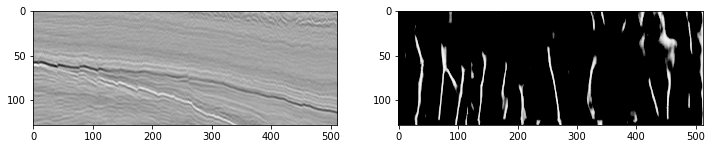

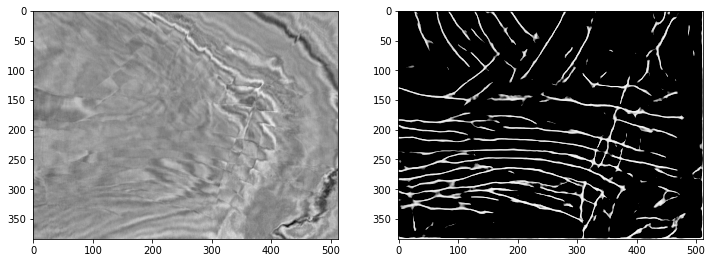

In [ ]:
from matplotlib.colors import Normalize
from PIL import Image
gx,m1,m2,m3 = np.fromfile("/content/drive/MyDrive/Python/UNET/f3d/gxl.dat",dtype=np.single),512,384,128
gy.tofile("/content/drive/MyDrive/Python/UNET/f3d/"+"fp.dat",format="%4")
gx = np.reshape(gx,(m1,m2,m3))
gy = np.reshape(gy,(m1,m2,m3))

k1,k2,k3 = 29,29,99
gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)